In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import preprocessor as p

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
encoded_label_dict = {"negative" : 0, "positive" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [5]:
fp = "../data/imdb/IMDB Dataset.csv"
df = pd.read_csv(fp)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df["target"] = df["sentiment"].apply(lambda x: encode_label(x))

In [5]:
def preprocess(txt):
    return p.clean(txt)

In [9]:
df["clean_review"] = df["review"].apply(lambda x: preprocess(x))

In [10]:
df.head()

,review,sentiment,target,clean_review
0,One of the other reviewers has mentioned that ...,positive,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...,positive,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"Petter Mattei's ""Love in the Time of Money"" is..."


In [11]:
df.target.value_counts()

1    25000
0    25000
Name: target, dtype: int64

In [5]:
# df.to_csv("../data/imdb/imdb_preprocessed_reviews.csv",index=None)

fp = "../data/imdb/imdb_preprocessed_reviews.csv"
df = pd.read_csv(fp)

<AxesSubplot:>

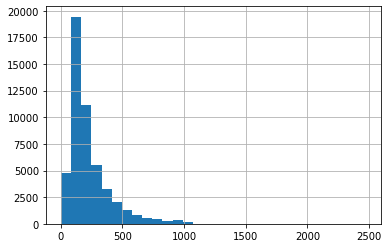

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df.clean_review]

pd.Series(seq_len).hist(bins = 30)

In [6]:
model_name = "bert-base-cased"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-05

In [7]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [8]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.clean_review[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [9]:
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2022)
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, stratify=None, random_state=2022)

In [10]:
# Creating the dataset and dataloader
train_dataset = train.reset_index(drop=True)
valid_dataset = valid.reset_index(drop=True)
test_dataset = test.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
validating_set = Triage(valid_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (50000, 4)
TRAIN Dataset: (40000, 4)
VALID Dataset: (5000, 4)
TEST Dataset: (5000, 4)


In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

In [12]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [13]:
def validate(model, testing_loader):
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    state = torch.get_rng_state()
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, attention_mask=mask, labels=targets)
            loss = outputs.loss
            logits = outputs.logits
            tr_loss += loss
            big_val, big_idx = torch.max(logits, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    torch.set_rng_state(state)
    return epoch_loss, epoch_accu

In [14]:
# Defining the training function on the 80% of the dataset for tuning the roberta model
def train(epoch, training_loader, testing_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        
        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask, labels=targets)
        loss = outputs.loss
        logits = outputs.logits
        tr_loss += loss
        big_val, big_idx = torch.max(logits, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _!=0 and _%100==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 100 steps: {loss_step}")
            print(f"Training Accuracy per 100 steps: {accu_step}")

        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    
    valid_loss, valid_accu = validate(model,testing_loader)
    return model, epoch_loss, epoch_accu, valid_loss, valid_accu

In [15]:
torch.manual_seed(2022)

model = BertForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Creating the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

running_val_loss = float('inf')
running_trn_loss = float('inf')
trn_losses = []
val_losses = []
for epoch in range(EPOCHS):
    m, trn_loss, trn_acc, val_loss, val_acc = train(epoch, training_loader, validating_loader)
    trn_losses.append(trn_loss)
    val_losses.append(val_loss)
    if (val_loss < running_val_loss) and (val_loss < trn_loss):
        running_val_loss = val_loss
        running_trn_loss = trn_loss
        # Save the best model
        output_model_file = f'../models/best-ft-bert-cased-imdb-sentiment-maxlen128-bs16.pt'
        model_to_save = m
        torch.save(model_to_save, output_model_file)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Training Loss per 100 steps: 0.6118298768997192
Training Accuracy per 100 steps: 64.85148514851485
Training Loss per 100 steps: 0.4989476501941681
Training Accuracy per 100 steps: 74.28482587064677
Training Loss per 100 steps: 0.45078977942466736
Training Accuracy per 100 steps: 77.55398671096346
Training Loss per 100 steps: 0.43292152881622314
Training Accuracy per 100 steps: 78.88092269326684
Training Loss per 100 steps: 0.4185851514339447
Training Accuracy per 100 steps: 79.87774451097805
Training Loss per 100 steps: 0.40553203225135803
Training Accuracy per 100 steps: 80.76123128119801
Training Loss per 100 steps: 0.3975709080696106
Training Accuracy per 100 steps: 81.13409415121255
Training Loss per 100 steps: 0.3879895508289337
Training Accuracy per 100 steps: 81.74937578027466
Training Loss per 100 steps: 0.3800363838672638
Training Accuracy per 100 steps: 82.31825749167592
Training Loss per 100 steps: 0.372728168964386
Training Accuracy per 100 steps: 82.7485014985015
Training 

KeyboardInterrupt: 

#### Inference

In [20]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

In [21]:
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [22]:
model = torch.load('../models/best-ft-bert-cased-painpoint-maxlen35-bs16.pt')

In [16]:
def predict(query, model, tokenizer, device="cuda"):
    tokens = tokenizer.encode(query)
    all_tokens = len(tokens)
    tokens = tokens[:tokenizer.model_max_length - 2]
    used_tokens = len(tokens)
    # tokens = torch.tensor([tokenizer.bos_token_id] + tokens + [tokenizer.eos_token_id]).unsqueeze(0)
    tokens = torch.tensor([tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]).unsqueeze(0)
    mask = torch.ones_like(tokens)

    with torch.no_grad():
        logits = model(tokens.to(device), attention_mask=mask.to(device))[0]
        probs = logits.softmax(dim=-1)

    fake, real = probs.detach().cpu().flatten().numpy().tolist()
    return real

In [17]:
# # Import tokenizer from transformers package
# from transformers import BertTokenizer

# # Load the tokenizer of the "bert-base-cased" pretrained model
# # See https://huggingface.co/transformers/pretrained_models.html for other models
# tz = BertTokenizer.from_pretrained("bert-base-cased")

# # The senetence to be encoded
# sent = "Let's learn deep learning!"

# # Encode the sentence
# encoded = tz.encode_plus(
#     text=sent,  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 64,  # maximum length of a sentence
#     pad_to_max_length=True,  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors
# )

# # Get the input IDs and attention mask in tensor format
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']

In [18]:
preds, preds_probas = [],[]
for i, row in test_dataset.iterrows():
    query = row["clean_review"]
    pred = predict(query,model,tokenizer)
    preds_probas.append(pred)
    if pred >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors


In [19]:
from sklearn.metrics import confusion_matrix
y_true = test_dataset.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

array([[2426,  112],
       [ 280, 2182]])

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

In [21]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}")

Accuracy: 92.16; Precision:95.1176983435048; Recall:88.62713241267262


In [22]:
print(classification_report(y_true, y_pred, target_names=["n","y"]))

              precision    recall  f1-score   support

           n       0.90      0.96      0.93      2538
           y       0.95      0.89      0.92      2462

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

